## circle abstraction for chemical structure graphs
In this notebook I show how to use Graphlearn with abstract graphs to generate molecules with an abstraction 
that deals with circular motives.

### initialising

In [1]:
%load_ext autoreload
%autoreload 2
from eden.util import configure_logging
import logging
configure_logging(logging.getLogger(),verbosity=1)
%matplotlib inline



### get_graphs will provide data( networkx graphs )

In [2]:
from eden.converter.graph.gspan import gspan_to_eden
from itertools import islice

def get_graphs(dataset_fname='../toolsdata/bursi.pos.gspan', size=100):
    return  islice(gspan_to_eden(dataset_fname),size)
 


## I demonstrate what an abstract graph looks like 


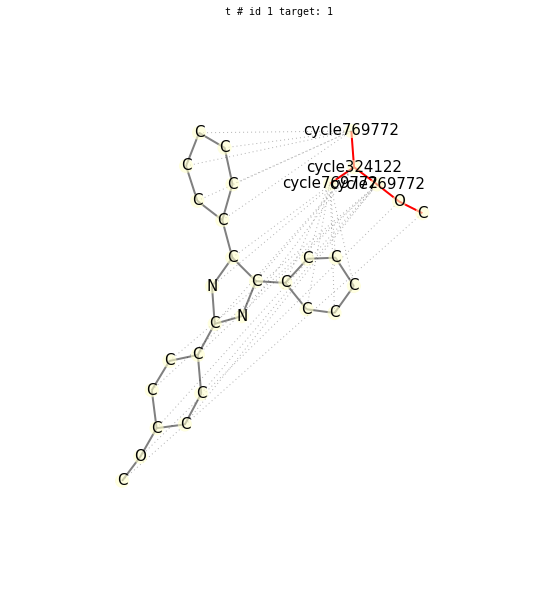

In [3]:

from graphlearn.utils import draw
import graphlearn.abstract_graphs.molecules_circle as mole
from graphlearn.graphlearn import Sampler as GLS
from eden.graph import Vectorizer

# get a graph and prepare it
graphs=get_graphs()
g=graphs.next()
vectorizer=Vectorizer()
g=vectorizer._graph_preprocessing(g)

#the preprocessor makes the abstraction, wrapper provides convenient format for drawing
preproc=mole.PreProcessor()
preproc.set_param(vectorizer)
graph_wrapper=preproc.wrap(g)
graph=graph_wrapper.graph(nested=True)


# draw 
draw.graphlearn(graph,size=10, abstract_color='red', contract=True,ignore_for_layout='nesting')


## Here we see different views on a graph, provided by the wrapper,

for the sampling process CIPs need to be extracted. 
here we see this mechanism. 

DEMONSTRATING WRAPPER
grammar example 0


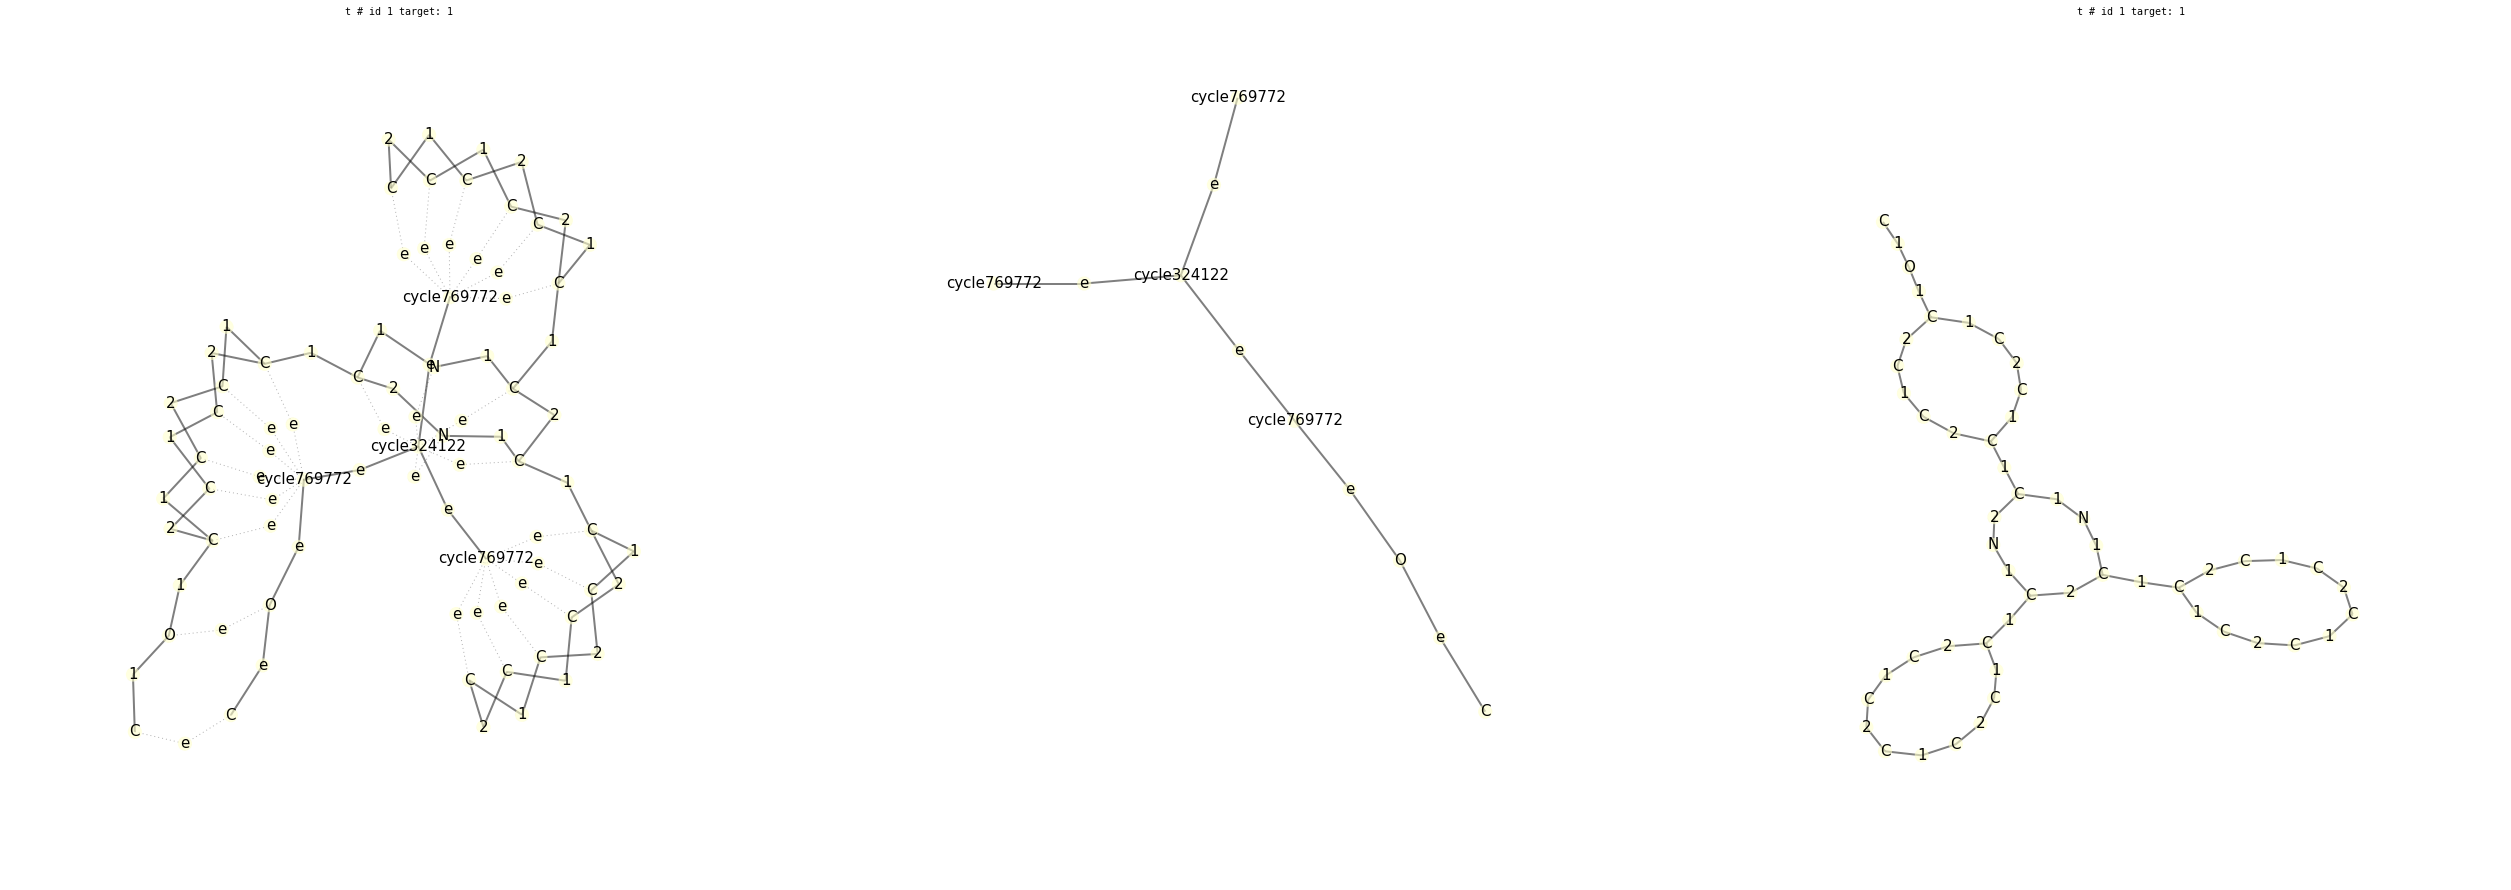

DEMONSTRATING EXTRACTION


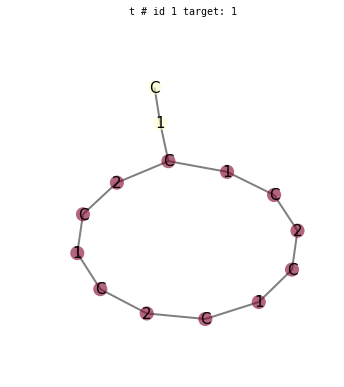

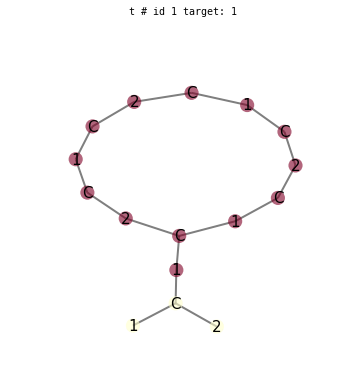

In [4]:
from graphlearn.utils import draw
import graphlearn.abstract_graphs.molecules_circle as mole
from graphlearn.graphlearn import Sampler as GLS
from eden.graph import Vectorizer

vectorizer=Vectorizer()

print 'DEMONSTRATING WRAPPER'
graphs=get_graphs()
for i in range(1):
    print 'grammar example %d' % i
    g=graphs.next()
    gm=preproc.wrap(g)
    draw.graphlearn([gm.graph(nested=True),gm.abstract_graph(),gm.base_graph()], 
                    size = 15,
                    vertex_label = 'label',
                    contract=False)

    
print 'DEMONSTRATING EXTRACTION'  
radius_list=[0,2]
thickness_list=[2,4]
base_thickness_list=[2]
argz=(gm,radius_list,thickness_list,Vectorizer(),2**20-1,lambda x,y:True, base_thickness_list)

cips=gm.all_core_interface_pairs(thickness_list=[2],radius_list=[0,1],hash_bitmask=2**20-1)
draw.graphlearn(cips[0][0].graph, contract=False)
draw.graphlearn(cips[0][1].graph, contract=False)


## here we prepare a sampler and then take a closer look at the generated grammar.


In [5]:
%%time
import graphlearn.abstract_graphs.molecules_circle as mole
from graphlearn.graphlearn import Sampler as GLS
graphs = get_graphs(size=200)
sampler=GLS(radius_list=[0,1],
            thickness_list=[1], 
            min_cip_count=2, 
            min_interface_count=2, 
            preprocessor=mole.PreProcessor(base_thickness_list=[2]))
sampler.fit(graphs,grammar_n_jobs=1,grammar_batch_size=1)

CPU times: user 8.96 s, sys: 344 ms, total: 9.3 s
Wall time: 11.2 s


interface id: 553552 [23 options]


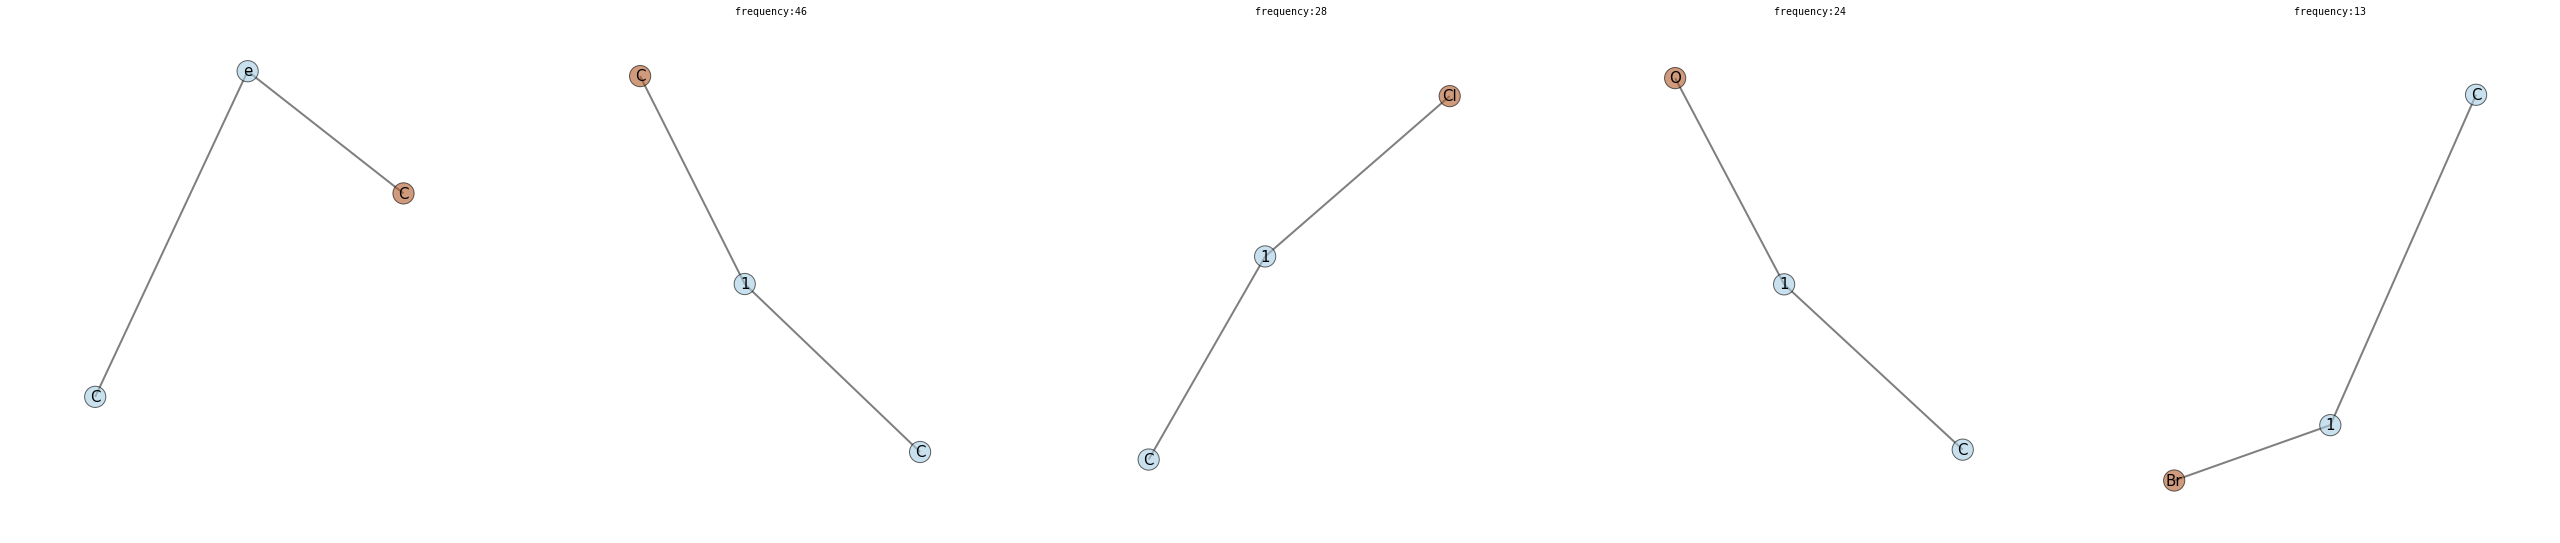

interface id: 646356 [16 options]


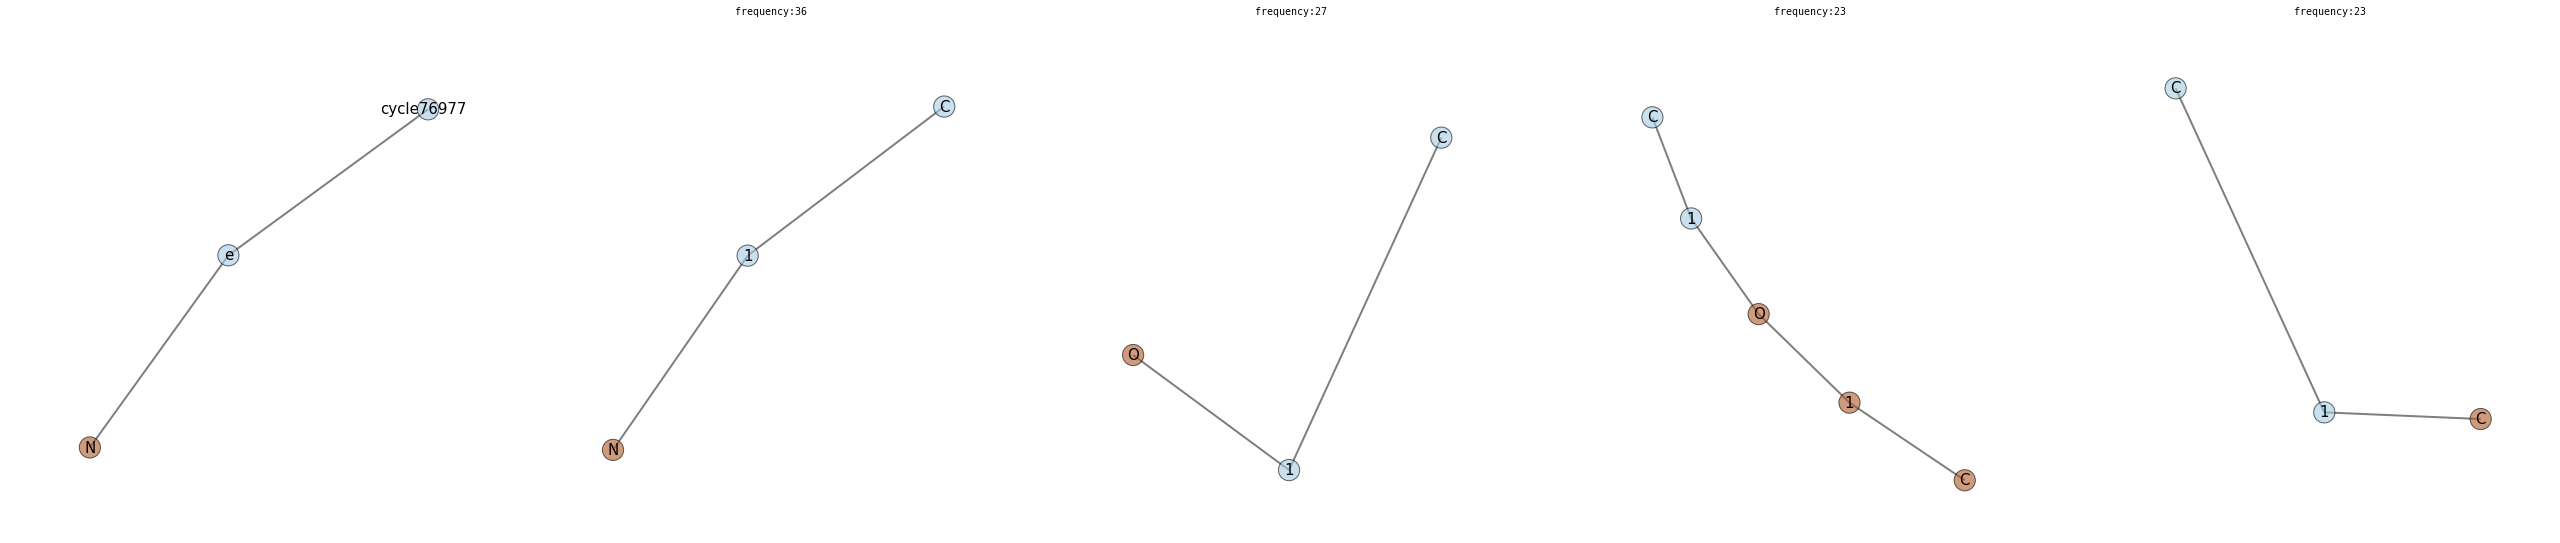

interface id: 735458 [15 options]


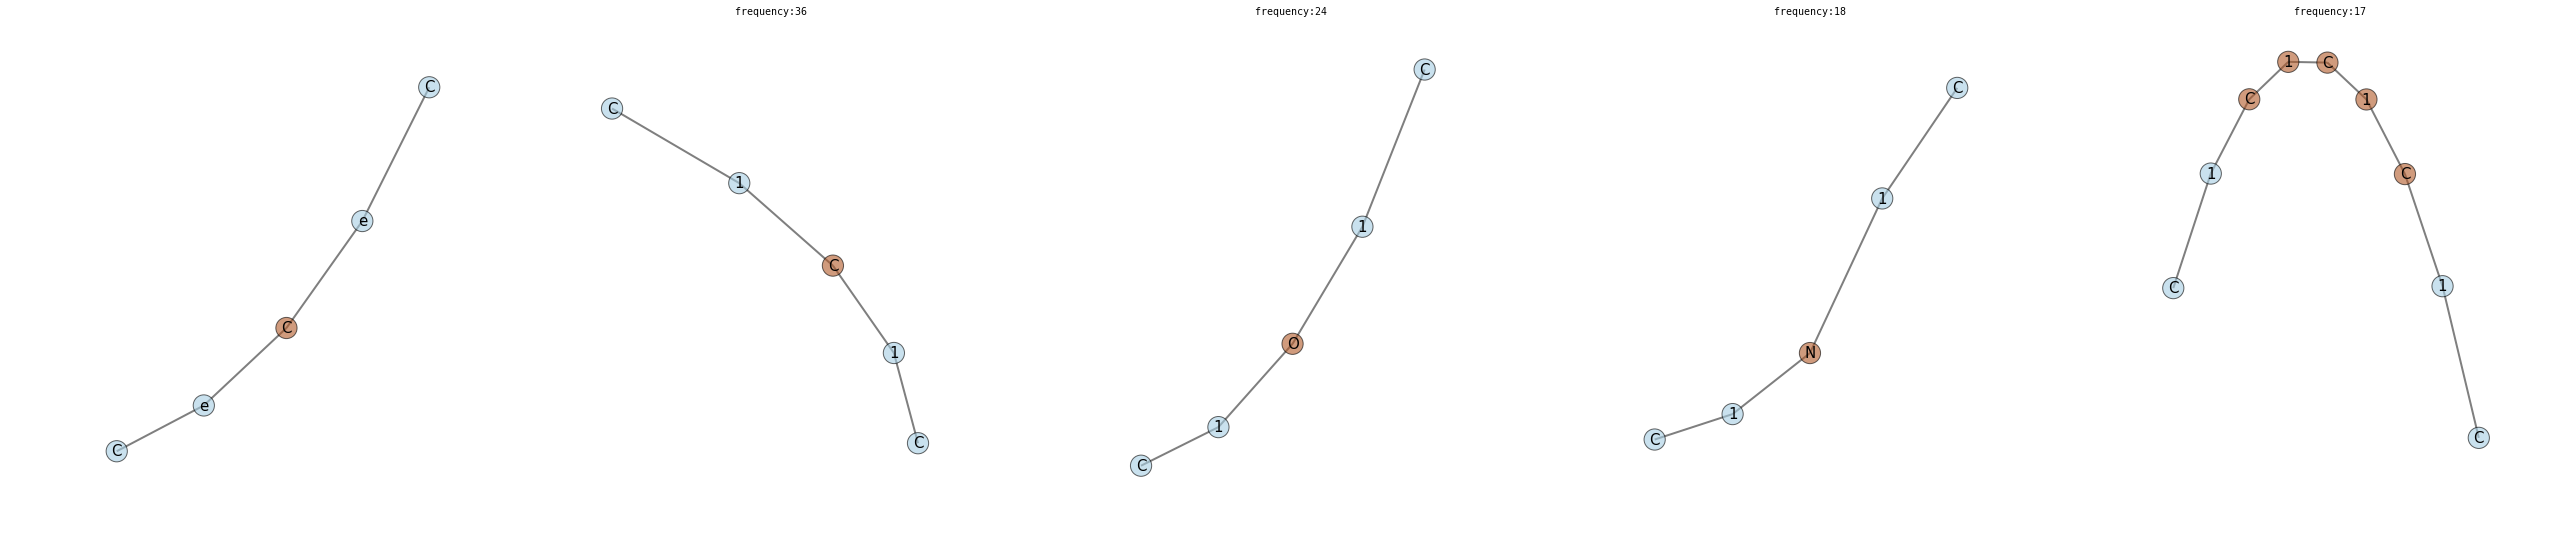

interface id: 151696 [15 options]


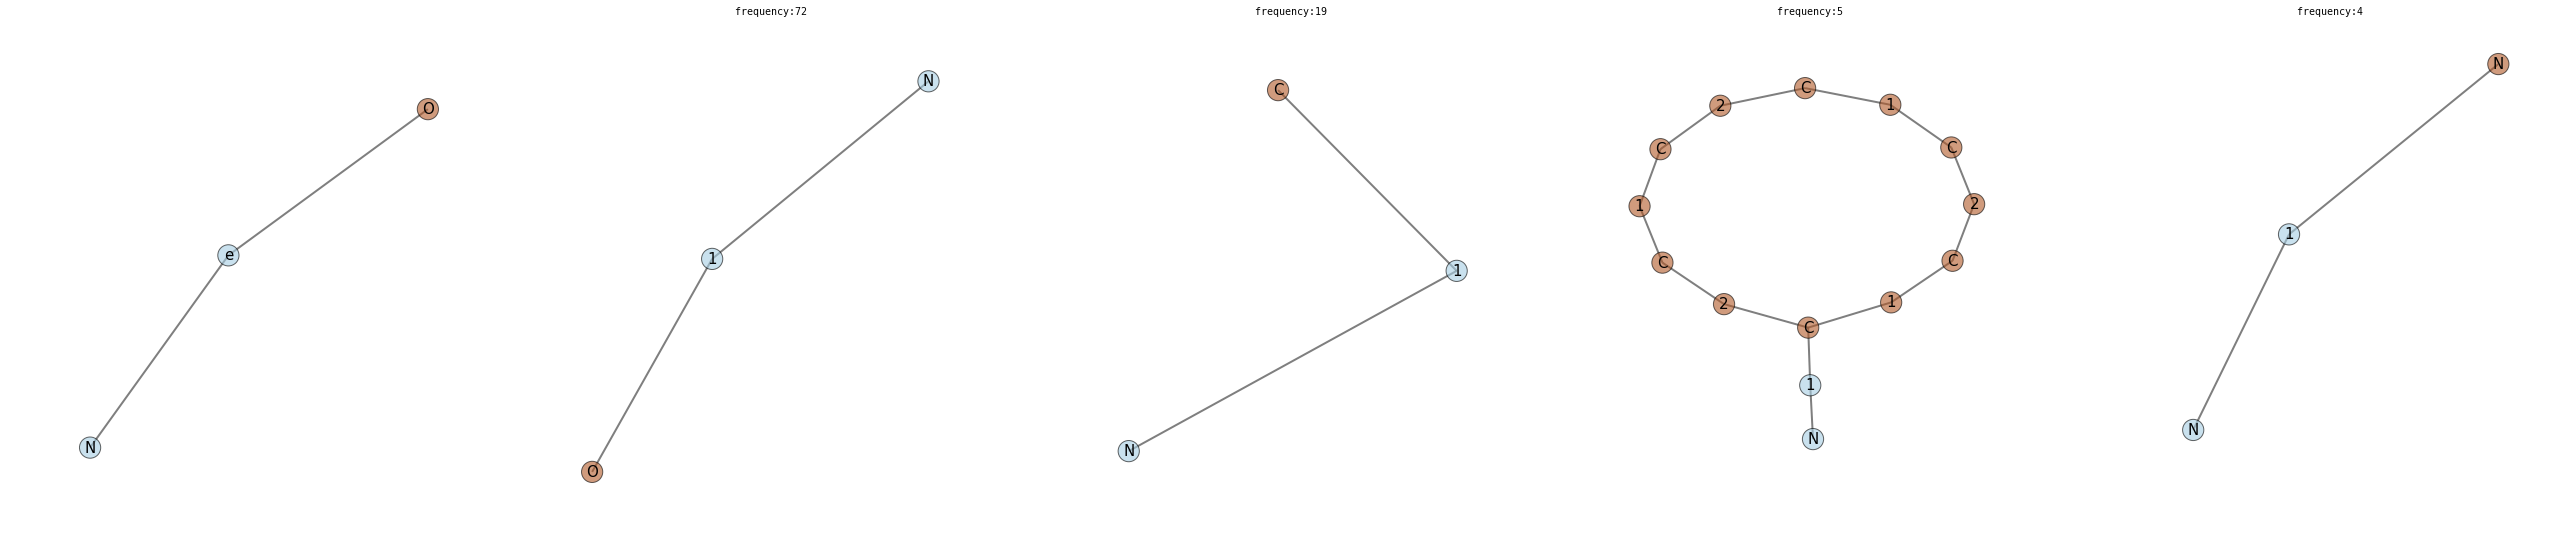

interface id: 538594 [14 options]


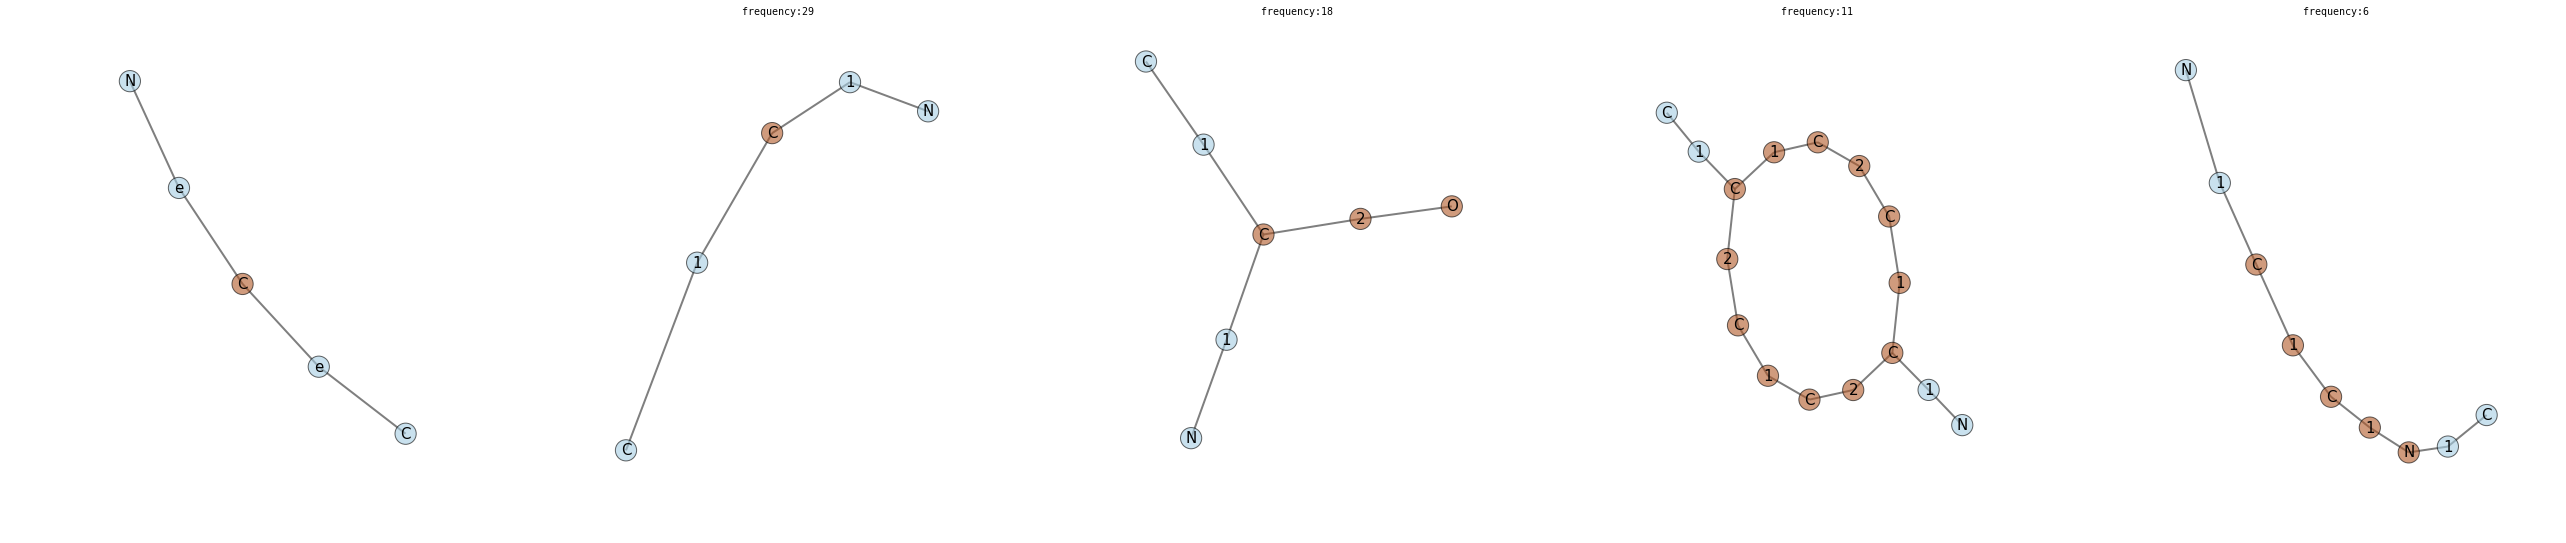

In [6]:
#show congruent cips in grammar
draw.draw_grammar(sampler.lsgg.productions,n_productions=5,n_graphs_per_production=5,
                     n_graphs_per_line=5, size=9, contract=False,
                     colormap='Paired', invert_colormap=False,node_border=1,
                     vertex_alpha=0.6, edge_alpha=0.5, node_size=450, abstract_interface=True)

    

## Molecule sampling

In [7]:
%%time
import graphlearn.utils.draw as draw
from graphlearn.utils import openbabel
import graphlearn.abstract_graphs.molecules_circle as mole
import itertools

# parameters
graphs = get_graphs()
id_start=15
id_end=id_start+9
graphs = itertools.islice(graphs,id_start,id_end)
n_steps=100


#sampling
graphs = sampler.sample(graphs,
                        n_samples=5,
                        batch_size=1,
                        n_steps=n_steps,
                        n_jobs=1,
                        quick_skip_orig_cip=True,
                        probabilistic_core_choice=False,
                        burnin=0,
                        improving_threshold=0.5,
                        max_size_diff=10,
                        select_cip_max_tries=100,
                        keep_duplicates=True,
                        include_seed=True)

 
scores=[]
ids=range(id_start,id_end)
for i,path_graphs in enumerate(graphs):
    # path_graphs is a list of 'sampled' graphs for 1 run 
    print 'Graph id: %d'%(ids[i])
    #save score
    scores.append(sampler.monitors[i].sampling_info['score_history'])
    # draw
    #draw.graphlearn(path_graphs,
    #                       n_graphs_per_line=5, size=10, 
    #                       colormap='Paired', invert_colormap=False,node_border=0.5, vertex_color='color_level',
    #                       vertex_alpha=0.5, edge_alpha=0.7, node_size=450,edge_label='label'  )
    openbabel.draw(path_graphs)

Graph id: 15


Graph id: 16


Graph id: 17


Graph id: 18


Graph id: 19


Graph id: 20


Graph id: 21


Graph id: 22


Graph id: 23


CPU times: user 18.1 s, sys: 36 ms, total: 18.1 s
Wall time: 18.1 s


## show score history for each samplerun

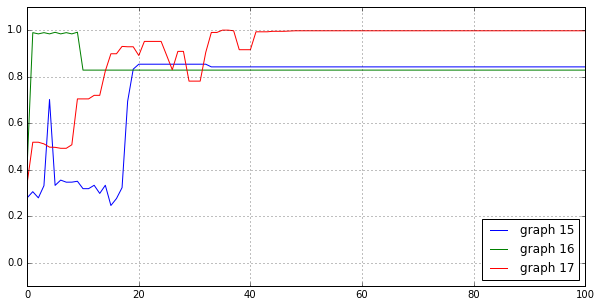

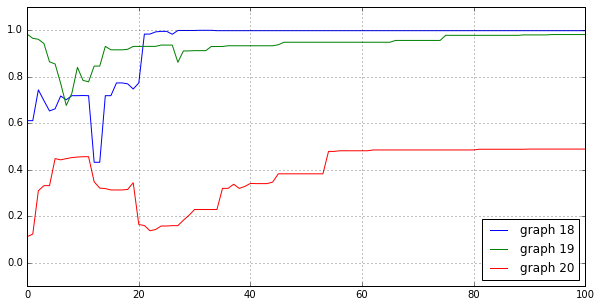

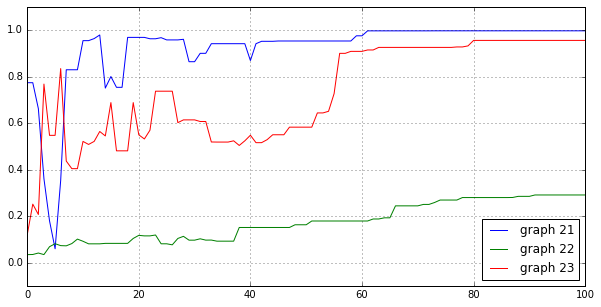

In [8]:
%matplotlib inline
from itertools import islice
import numpy as np
import matplotlib.pyplot as plt
step=1
num_graphs_per_plot=3
num_plots=np.ceil([len(scores)/num_graphs_per_plot])
for i in range(num_plots):
    plt.figure(figsize=(10,5))
    for j,score in enumerate(scores[i*num_graphs_per_plot:i*num_graphs_per_plot+num_graphs_per_plot]):
        data = list(islice(score,None, None, step))
        plt.plot(data, label='graph %d'%(j+i*num_graphs_per_plot+id_start))
    plt.legend(loc='lower right')
    plt.grid()
    plt.ylim(-0.1,1.1)
    plt.show()

---